# Part 1: Generate Data

In [289]:
import numpy as np
import matplotlib.pyplot as plt

dimension_count = 2
sd = 3
centers_count = 10
centers_mean = 0
centers_covariance = sd

np.random.seed(8067)

centers0 = np.random.normal(loc=centers_mean, scale=centers_covariance, size=(centers_count, dimension_count))
centers1 = np.random.normal(loc=centers_mean, scale=centers_covariance, size=(centers_count, dimension_count))

In [290]:
def generate_samples():
    centers_indices = np.arange(centers_count)
    train_size = 100
    test_size = 5000
    sample_size = train_size + test_size
    samples_sd = 0.5
    
    selected_centers0 = np.random.choice(centers_indices, size=sample_size)
    selected_centers0 = centers0[selected_centers0] # grab randomly selected centers
    samples0 = np.random.normal(loc=selected_centers0, scale=samples_sd, size=(sample_size, dimension_count))
    samples0 = np.append(samples0, np.zeros(sample_size).reshape(sample_size, 1), axis=1) # add column of 0's
    
    selected_centers1 = np.random.choice(centers_indices, size=sample_size)
    selected_centers1 = centers1[selected_centers1] # grab randomly selected centers
    samples1 = np.random.normal(loc=selected_centers1, scale=samples_sd, size=(sample_size, dimension_count))
    samples1 = np.append(samples1, np.ones(sample_size).reshape(sample_size, 1), axis=1) # add column of 1's

    train_samples = np.concatenate([samples0[:train_size], samples1[:train_size]])
    np.random.shuffle(train_samples)
    
    test_samples = np.concatenate([samples0[train_size:], samples1[train_size:]])
    np.random.shuffle(test_samples)

    return train_samples, test_samples

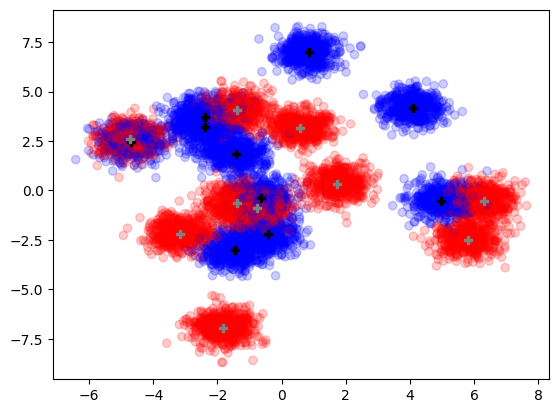

In [310]:
train_samples, test_samples = generate_samples()

colors = ["blue" if sample[2] == 0 else "red" for sample in train_samples]
labels = ["class 0" if sample[2] == 0 else "class 1" for sample in train_samples]
plt.scatter(train_samples[:, 0], train_samples[:, 1], c=colors, label=labels, alpha=0.2)

colors = ["blue" if sample[2] == 0 else "red" for sample in test_samples]
labels = ["class 0" if sample[2] == 0 else "class 1" for sample in test_samples]
plt.scatter(test_samples[:, 0], test_samples[:, 1], c=colors, label=labels, alpha=0.2)

plt.scatter(centers0[:, 0], centers0[:, 1], c="black", marker="P")
plt.scatter(centers1[:, 0], centers1[:, 1], c="gray", marker="P")

# plt.legend()

# Part 2: kNN

In [296]:
def kNN(train, test, k):
    predictions = []
    
    for i in range (test.shape[0]):
        distances = np.linalg.norm(train[:, :2] - test[i, :2], axis=1)
        distances = distances.reshape(distances.shape[0], 1)
        
        indices = np.arange(distances.shape[0])
        distances = np.append(distances, indices.reshape(distances.shape[0], 1), axis=1)
    
        distances = distances[distances[:, 0].argsort()]
        
        closest_points_indices = distances[:k][:, 1].astype(int)
        closest_points_class = train[closest_points_indices][:, 2]
    
        prediction = np.sum(closest_points_class) > (k / 2)
        predictions.append(prediction)
    
    return predictions

## Implementation

#### Distances Ties

From Numpy documentation for `argsort`:

When a is an array with fields defined, this argument specifies which fields to compare first, second, etc. A single field can be specified as a string, and not all fields need be specified, but unspecified fields will still be used, in the order in which they come up in the dtype, to break ties.

So precedent is given to training entry with lower index, which is random since we shuffled the dataset.

#### Voting Ties

If equal number of votes, then precedent is given to the `0` class

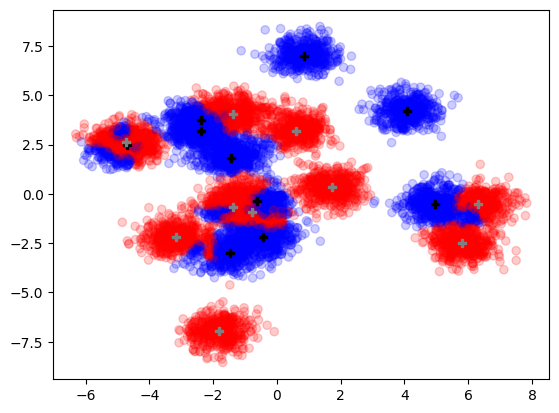

In [299]:
predictions = kNN(train_samples, test_samples, 1)

colors = ["red" if prediction else "blue" for prediction in predictions]
plt.scatter(test_samples[:, 0], test_samples[:, 1], alpha=0.2, c=colors)

plt.scatter(centers0[:, 0], centers0[:, 1], c="black", marker="P")
plt.scatter(centers1[:, 0], centers1[:, 1], c="gray", marker="P")

In [300]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [301]:
print("1-NN Confusion Matrices (top is own implementation, bottom is sklearn)")

predictions_self = kNN(train_samples, test_samples, 1)
print(confusion_matrix(test_samples[:, 2], predictions_self))

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(train_samples[:, :2], train_samples[:, 2])
predictions_sklearn = neigh.predict(test_samples[:, :2])
print(confusion_matrix(test_samples[:, 2], predictions_sklearn))

print("3-NN Confusion Matrices (top is own implementation, bottom is sklearn)")

predictions_self = kNN(train_samples, test_samples, 3)
print(confusion_matrix(test_samples[:, 2], predictions_self))

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_samples[:, :2], train_samples[:, 2])
predictions_sklearn = neigh.predict(test_samples[:, :2])
print(confusion_matrix(test_samples[:, 2], predictions_sklearn))

print("5-NN Confusion Matrices (top is own implementation, bottom is sklearn)")

predictions_self = kNN(train_samples, test_samples, 5)
print(confusion_matrix(test_samples[:, 2], predictions_self))

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(train_samples[:, :2], train_samples[:, 2])
predictions_sklearn = neigh.predict(test_samples[:, :2])
print(confusion_matrix(test_samples[:, 2], predictions_sklearn))

1-NN Confusion Matrices (top is own implementation, bottom is sklearn)
[[4102  898]
 [ 754 4246]]
[[4102  898]
 [ 754 4246]]
3-NN Confusion Matrices (top is own implementation, bottom is sklearn)
[[4014  986]
 [ 584 4416]]
[[4014  986]
 [ 584 4416]]
5-NN Confusion Matrices (top is own implementation, bottom is sklearn)
[[4010  990]
 [ 551 4449]]
[[4010  990]
 [ 551 4449]]


# Part 3: cvKNN

In [304]:
import sys

def cv_knn(train_samples, fold_count):
    n = train_samples.shape[0]
    fold_count = 10
    fold_size = n // fold_count
    
    min_error = sys.maxsize
    best_k = -1
    for k in range(1, n - fold_size + 1):
    
        if k % 20 == 0:
            print("Currently testing: ", k)
            
        average_error = 0
        
        for i in range(fold_count):
            start = i * fold_size
            end = (i + 1) * fold_size
            
            holdout = train_samples[start:end]
            train_data = np.concatenate([train_samples[end:], train_samples[:start]])
        
            neigh = KNeighborsClassifier(n_neighbors=k)
            neigh.fit(train_data[:, :2], train_data[:, 2])
            predictions_sklearn = neigh.predict(holdout[:, :2])
        
            matrix = confusion_matrix(holdout[:, 2], predictions_sklearn)
            error = (matrix[0, 1] + matrix[1, 0]) / holdout.shape[0]
            average_error = ((average_error * i) + error) / (i + 1)
        
        if average_error <= min_error:
            min_error = average_error
            best_k = k

    return best_k

cv_knn_best_k = cv_knn(train_samples, 10)
print(cv_knn_best_k)

Currently testing:  20
Currently testing:  40
Currently testing:  60
Currently testing:  80
Currently testing:  100
Currently testing:  120
Currently testing:  140
Currently testing:  160
Currently testing:  180


# Part 4: Bayes Rule

In [265]:
def bayes_prob_predictions(centers0, centers1, test_samples, sd):
    class0_probs = np.zeros((test_samples.shape[0]))
    for center in centers0:
        distance = -np.linalg.norm(test_samples[:, :2] - center, axis=1)**2
        class0_probs += np.exp(distance / (2 * sd**2))
    
    class1_probs = np.zeros((test_samples.shape[0]))
    for center in centers1:
        distance = -np.linalg.norm(test_samples[:, :2] - center, axis=1)**2
        class1_probs += np.exp(distance / (2 * sd**2))

    bayes_prob = class0_probs / class1_probs
    return np.where(bayes_prob > 1, 0, 1)

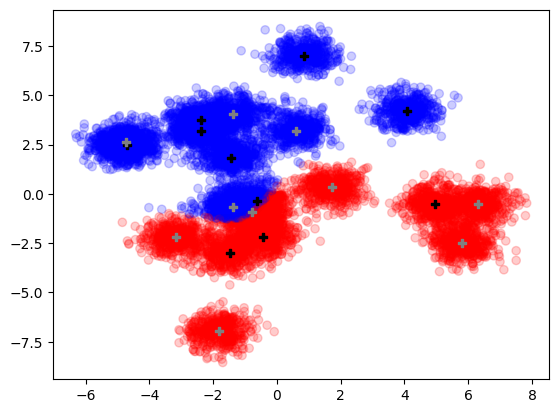

In [303]:
bayes_predictions = bayes_prob_predictions(centers0, centers1, test_samples, centers_covariance)

colors = ["red" if prediction else "blue" for prediction in bayes_predictions]
plt.scatter(test_samples[:, 0], test_samples[:, 1], alpha=0.2, c=colors)

plt.scatter(centers0[:, 0], centers0[:, 1], c="black", marker="P")
plt.scatter(centers1[:, 0], centers1[:, 1], c="gray", marker="P")

In [269]:
nib = centers1[0] - test_samples[:, :2]
print(nib.shape)

(10000, 2)


# Part 5: Simulation Study

In [305]:
num_simulations = 50

n = test_samples.shape[0]

knn_errors = np.zeros(num_simulations)
cvknn_errors = np.zeros(num_simulations)
bayes_errors = np.zeros(num_simulations)

for i in range(num_simulations):
    if i % 5 == 0:
        print("Iteration No.", i)
    
    new_train_samples, new_test_samples = generate_samples()
    test_labels = new_test_samples[:, 2]
    
    knn_predictions = kNN(new_train_samples, new_test_samples, 7)
    correct_predictions = np.sum(np.equal(test_labels, knn_predictions))
    knn_errors[i] = 1 - (correct_predictions / n)

    cvknn_predictions = kNN(new_train_samples, new_test_samples, cv_knn_best_k)
    correct_predictions = np.sum(np.equal(test_labels, cvknn_predictions))
    cvknn_errors[i] = 1 - (correct_predictions / n)

    bayes_predictions = bayes_prob_predictions(centers0, centers1, new_test_samples, centers_covariance)
    correct_predictions = np.sum(np.equal(test_labels, bayes_predictions))
    bayes_errors[i] = 1 - (correct_predictions / n)

Iteration No. 0
Iteration No. 5
Iteration No. 10
Iteration No. 15
Iteration No. 20
Iteration No. 25
Iteration No. 30
Iteration No. 35
Iteration No. 40
Iteration No. 45


In [314]:
def print_summary_statistics(model_name, min, max, first_q, second_q, third_q):
    print("#############")
    print(model_name, "Error Rate Summary Statistics")
    print("#############")
    print("Min: ", min)
    print("Max: ", max)
    print("25% Quantile: ", first_q)
    print("50% Quantile: ", second_q)
    print("75% Quantile: ", third_q)

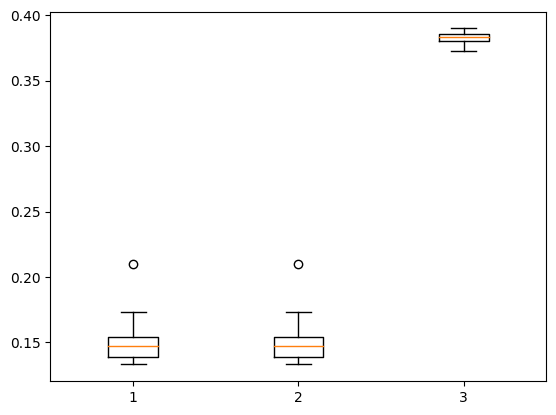

#############
7-NN Error Rate Summary Statistics
#############
Min:  0.1331
Max:  0.21009999999999995
25% Quantile:  0.13874999999999998
50% Quantile:  0.14689999999999998
75% Quantile:  0.15407500000000002
#############
5-NN (chosen by CV) Error Rate Summary Statistics
#############
Min:  0.1331
Max:  0.21009999999999995
25% Quantile:  0.13874999999999998
50% Quantile:  0.14689999999999998
75% Quantile:  0.15407500000000002
#############
Bayes Rule Error Rate Summary Statistics
#############
Min:  0.3731
Max:  0.39
25% Quantile:  0.380475
50% Quantile:  0.3837
75% Quantile:  0.386125


In [316]:
plt.boxplot([knn_errors, cvknn_errors, bayes_errors])
plt.show()

print_summary_statistics("7-NN", np.min(knn_errors), np.max(knn_errors), 
                         np.quantile(knn_errors, 0.25), np.quantile(knn_errors, 0.5), 
                         np.quantile(knn_errors, 0.75))
print_summary_statistics("5-NN (chosen by CV)", np.min(cvknn_errors), np.max(cvknn_errors), 
                         np.quantile(cvknn_errors, 0.25), np.quantile(cvknn_errors, 0.5), 
                         np.quantile(cvknn_errors, 0.75))
print_summary_statistics("Bayes Rule", np.min(bayes_errors), np.max(bayes_errors), 
                         np.quantile(bayes_errors, 0.25), np.quantile(bayes_errors, 0.5), 
                         np.quantile(bayes_errors, 0.75))